<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1467573037292355367
xla_global_id: -1
]


In [162]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tf_keras

from keras import layers
from keras import models
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization
from keras.models import load_model

In [163]:
num_classes = 10

In [164]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [165]:
np.transpose(y_train).shape

(60000,)

In [166]:
y_train.shape

(60000,)

In [167]:
def drow_hist(data):
  plt.figure(figsize=(8,6), dpi= 80)
  _ = plt.hist(data,
              bins=num_classes,
              stacked=True,
              density=False,
              range=(0,10),
              rwidth=0.9,
              )

In [168]:
# create validation data
val_size = 10000

x_val = x_train[-val_size:, :, :]
x_train = x_train[:-val_size, :, :]

y_val = y_train[-val_size:]
y_train = y_train[:-val_size]

In [169]:
# mirror train image
x_train_add = np.rot90(x_train, k=1, axes=(1,2))
x_train_add = np.transpose(x_train_add, (0, 2, 1))

In [170]:
y_train_add = y_train.copy()

In [171]:
# remove boots image from addition data [5, 7, 9]
for i in [5, 7, 9]:
    index = np.where(y_train_add == i )
    x_train_add = np.delete(x_train_add, index , axis=0)
    y_train_add = np.delete(y_train_add, index , axis=0)

In [172]:
x_train_add.shape

(34972, 28, 28)

In [173]:
y_train_add.shape

(34972,)

In [174]:
x_train = np.concatenate([
    x_train,
    x_train_add[:10000:, :, :]
])

In [175]:
y_train = np.concatenate([
    y_train,
    y_train_add[:10000]
])

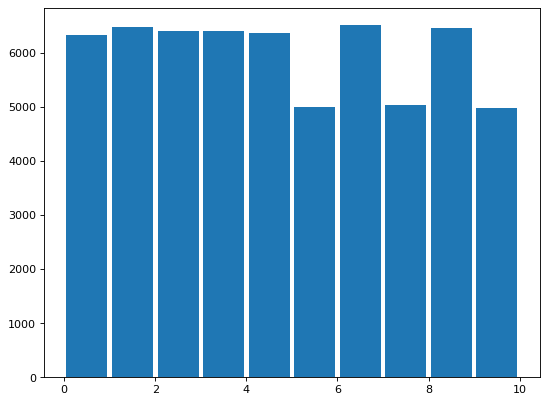

In [176]:
drow_hist(y_train)

In [177]:
# plt.figure()
# plt.imshow(x_train[7])
# plt.colorbar()
# plt.grid(False)
# plt.show()

In [178]:
# plt.figure()
# plt.imshow(x_train_add[0])
# plt.colorbar()
# plt.grid(False)
# plt.show()

In [179]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_val = x_val.astype('float32') / 255
y_val = y_val.astype('float32')

In [180]:
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(x_train[i+50000], cmap=plt.cm.binary)
#     plt.xlabel(class_names[int(y_train[i+50000])])
# plt.show()

In [181]:
# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(x_train[i], cmap=plt.cm.binary)
#     plt.xlabel(class_names[int(y_train[i])])
# plt.show()

In [182]:
w_init_tanh = initializers.glorot_normal(seed=111)
w_init_relu = initializers.HeNormal(seed=66)
# w_init_relu = initializers.HeUniform(seed=24)
b_init = initializers.Zeros()

In [183]:
drop_out = 0.33

In [184]:
def layer_relu(model, neurons):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                       activation='relu',
                       kernel_initializer=w_init_relu,
                       bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  return model

In [185]:
def layer_tanh(model, neurons):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                        activation='tanh',
                        kernel_initializer=w_init_tanh,
                        bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  return model

In [186]:
model = models.Sequential()

neurons = 256

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(drop_out))

model = layer_relu(model, neurons*1)
model = layer_relu(model, neurons*2)
model = layer_relu(model, neurons*2)
# model = layer_relu(model, neurons*1)


model.add(layers.Dense(10, activation='softmax'))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [187]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0003,
                                      beta_1=-0.10,
                                      beta_2=0.999,
                                      epsilon=1e-04
)
# optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.0005,
#                                                     rho=0.5,
#                                                     momentum=-16,
#                                                     epsilon=1e-07,
#                                                     centered=False,
#                                                     weight_decay=None,
#                                                     clipnorm=None,
#                                                     clipvalue=None,
#                                                     global_clipnorm=None,
#                                                     use_ema=False,
#                                                     ema_momentum=0.99,
#                                                     ema_overwrite_frequency=100,
#                                                     jit_compile=True,
#                                                     name='RMSprop',
# )

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [188]:
model.compile(#optimizer='adam',
              # optimizer='adamax',
              optimizer=optimizer,
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) # sparse_categorical_accuracy

In [189]:
# callback = callbacks.EarlyStopping(monitor='val_loss',
#                                    patience=15,
#                                    restore_best_weights=True,
#                                    )
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='sparse_categorical_accuracy', mode='max', verbose=0, save_best_only=True)


In [190]:
history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=128,
                    # callbacks=[callback],
                    callbacks=[mc, es],
                    verbose=1, #многословие
                    # validation_split=0.2
                    validation_data=(x_val, y_val)
                    )
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/200
469/469 [==============================] - 16s 28ms/step - loss: 1.0306 - sparse_categorical_accuracy: 0.6395 - val_loss: 0.5172 - val_sparse_categorical_accuracy: 0.8100
Epoch 2/200
469/469 [==============================] - 13s 27ms/step - loss: 0.6868 - sparse_categorical_accuracy: 0.7497 - val_loss: 0.4514 - val_sparse_categorical_accuracy: 0.8330
Epoch 3/200
469/469 [==============================] - 13s 27ms/step - loss: 0.6103 - sparse_categorical_accuracy: 0.7767 - val_loss: 0.4483 - val_sparse_categorical_accuracy: 0.8339
Epoch 4/200
469/469 [==============================] - 13s 27ms/step - loss: 0.5624 - sparse_categorical_accuracy: 0.7932 - val_loss: 0.4279 - val_sparse_categorical_accuracy: 0.8406
Epoch 5/200
469/469 [==============================] - 13s 27ms/step - loss: 0.5318 - sparse_categorical_accuracy: 0.8033 - val_loss: 0.4146 - val_sparse_categorical_accuracy: 0.8440
Epoch 6/200
469/469 [==============================] - 13s 27ms/step - loss: 0.5080 -

In [191]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']


In [192]:
result = model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 3ms/step - loss: 0.2985 - sparse_categorical_accuracy: 0.8936
[0.2984909117221832, 0.8935999870300293]


In [193]:
saved_model = load_model('best_model.h5')
result = saved_model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 3ms/step - loss: 0.2975 - sparse_categorical_accuracy: 0.8922
[0.2974729835987091, 0.8921999931335449]


In [194]:
# from keras.models import load_model
# saved_model = load_model('best_model.h5')
# # _, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
# _, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
# print('Test: %.3f' % (test_acc))

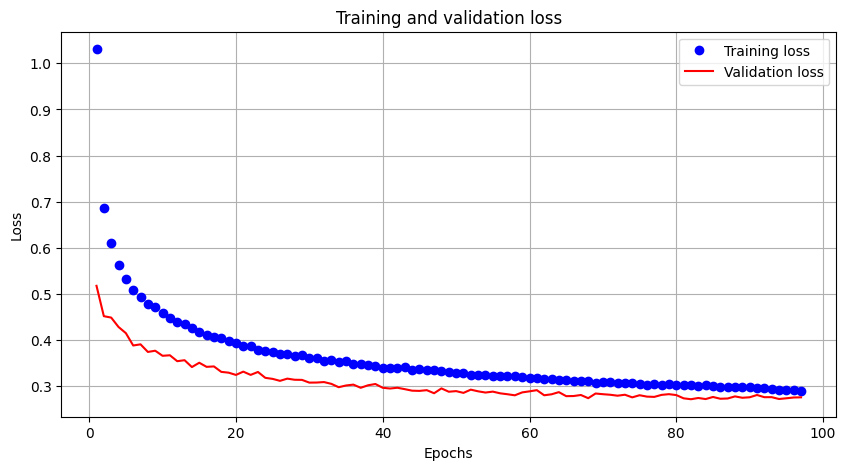

<Figure size 640x480 with 0 Axes>

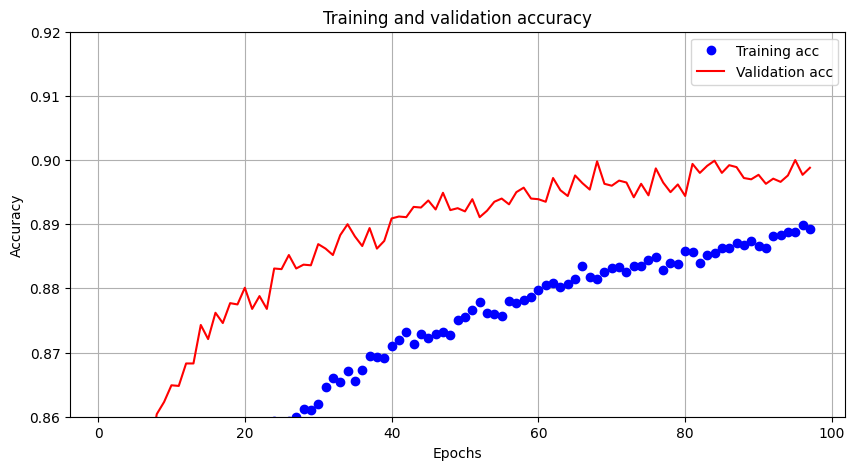

In [195]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
# plt.ylim (0.2, 0.5)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
1
plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'r', label='Validation acc')
plt.ylim (0.86, 0.92)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [196]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [197]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 2s 5ms/step


In [198]:
predictions[0]

array([0.08557664, 0.08557664, 0.08557664, 0.08557664, 0.08557664,
       0.08563599, 0.08557664, 0.0872031 , 0.08557664, 0.2281245 ],
      dtype=float32)

In [199]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dropout_16 (Dropout)        (None, 784)               0         
                                                                 
 batch_normalization_12 (Ba  (None, 784)               3136      
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (None, 256)               200960    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_13 (Ba  (None, 256)               1024      
 tchNormalization)                                    

In [200]:




hnyetjn hrte()

SyntaxError: invalid syntax (<ipython-input-200-1a3818e70946>, line 1)